In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
from metrics import ilisi, asw_batch

%load_ext autoreload
%autoreload 2

In [2]:
#path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/'
path_data='/net/bmc-lab4/data/kellis/users/khrovati/data/'
path_sub=path_data+'datasets/d10_1038_s41586-022-04518-2/SCP1376/'
path_save=path_data+'cross_system_integration/adipose_sc_sn_updated/'

# Prepare adatas from mtx

## Metadata of cells

In [ ]:
# Metadata for both sc and sn
meta=pd.read_table(path_sub+'metadata/metadata.scp.tsv',index_col=0,skiprows=[1])

In [ ]:
for col in meta.columns:
    print('\n***',col,meta[col].nunique())
    if meta[col].nunique()<30:
        print(meta[col].unique())
        display(meta[col].value_counts())

## Sc data

In [ ]:
fn=path_sub+'expression/618069d6771a5b396cca7a7d/HsDrop.counts'

In [ ]:
x=mmread(fn+'.mtx.gz')
features=pd.DataFrame(pd.read_table(fn+'.features.tsv.gz',header=None,index_col=0)[1])
features.index.name=None
features.columns=['gene_symbol']
barcodes=pd.read_table(fn+'.barcodes.tsv.gz',header=None,index_col=0)
barcodes.index.name=None

In [ ]:
adata=sc.AnnData(csr_matrix(x.T),var=features,obs=barcodes)
adata

In [ ]:
cols=['depot__ontology_label','donor_id','sex','disease__ontology_label',
    'fat__type','cell_cycle__phase','cluster','subcluster']
adata.obs[cols]=meta.loc[adata.obs_names,cols]

In [ ]:
for col in cols:
    print('\n***',col,adata.obs[col].nunique())
    if adata.obs[col].nunique()<30:
        print(adata.obs[col].unique())
        display(adata.obs[col].value_counts())

In [ ]:
pd.crosstab(adata.obs['subcluster'],adata.obs['cluster'])

In [ ]:
adata

In [ ]:
adata.write(path_sub+'HsDrop.h5ad')

## Sn data

In [ ]:
fn=path_sub+'expression/618065be771a5b54fcddaed6/Hs10X.counts'

In [ ]:
x=mmread(fn+'.mtx.gz')
features=pd.DataFrame(pd.read_table(fn+'.features.tsv.gz',header=None,index_col=0)[1])
features.index.name=None
features.columns=['gene_symbol']
barcodes=pd.read_table(fn+'.barcodes.tsv.gz',header=None,index_col=0)
barcodes.index.name=None

In [ ]:
adata=sc.AnnData(csr_matrix(x.T),var=features,obs=barcodes)
adata

In [ ]:
cols=['depot__ontology_label','donor_id','sex','disease__ontology_label',
    'fat__type','cell_cycle__phase','cluster','subcluster']
adata.obs[cols]=meta.loc[adata.obs_names,cols]

In [ ]:
for col in cols:
    print('\n***',col,adata.obs[col].nunique())
    if adata.obs[col].nunique()<30:
        print(adata.obs[col].unique())
        display(adata.obs[col].value_counts())

In [ ]:
pd.crosstab(adata.obs['subcluster'],adata.obs['cluster'])

In [ ]:
adata

In [ ]:
adata.write(path_sub+'Hs10X.h5ad')

# Combien adatas for training

Sn need to subset to same type of fat as sc as else there are a lot of unmatched cts. In cs dont need to remove cancer partients as this does not seem to affect fat.

In [3]:
# PP sc
adata_sc=sc.read(path_sub+'HsDrop.h5ad')
# Subset to fat type and annotated cells
adata_sc=adata_sc[adata_sc.obs.fat__type=="SAT",:]
adata_sc=adata_sc[~adata_sc.obs.cluster.isna(),:]
# metadata
adata_sc.obs['system']=0
adata_sc.obs=adata_sc.obs[['system','donor_id','cluster','subcluster']]


# Subset to expr genes and normalise
adata_sc=adata_sc[:,np.array((adata_sc.X>0).sum(axis=0)>20).ravel()].copy()
adata_sc.layers['counts']=adata_sc.X.copy()
sc.pp.normalize_total(adata_sc, target_sum=1e4)
sc.pp.log1p(adata_sc)
# HVG
sc.pp.highly_variable_genes(
     adata=adata_sc, n_top_genes=3000, flavor='cell_ranger', batch_key='donor_id', subset=True)

display(adata_sc)

/tmp/ipykernel_312512/1543660554.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sc.obs['system']=0


AnnData object with n_obs × n_vars = 28465 × 3000
    obs: 'system', 'donor_id', 'cluster', 'subcluster'
    var: 'gene_symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [4]:
# PP sn
adata_sn=sc.read(path_sub+'Hs10X.h5ad')
# Subset to fat type and annotated cells
adata_sn=adata_sn[adata_sn.obs.fat__type=="SAT",:]
adata_sn=adata_sn[~adata_sn.obs.cluster.isna(),:]
# metadata
adata_sn.obs['system']=1
adata_sn.obs=adata_sn.obs[['system','donor_id','cluster','subcluster']]


# Subset to expr genes and normalise
adata_sn=adata_sn[:,np.array((adata_sn.X>0).sum(axis=0)>20).ravel()].copy()
adata_sn.layers['counts']=adata_sn.X.copy()
sc.pp.normalize_total(adata_sn, target_sum=1e4)
sc.pp.log1p(adata_sn)
# HVG
sc.pp.highly_variable_genes(
     adata=adata_sn, n_top_genes=3000, flavor='cell_ranger', batch_key='donor_id', subset=True)

display(adata_sn)

/tmp/ipykernel_312512/528794825.py:7: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_sn.obs['system']=1


AnnData object with n_obs × n_vars = 57599 × 3000
    obs: 'system', 'donor_id', 'cluster', 'subcluster'
    var: 'gene_symbol', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [5]:
# Shared HVGs
shared_hvgs=list(set(adata_sc.var_names) & set(adata_sn.var_names))
len(shared_hvgs)

1346

Match cell type names

In [6]:
sorted(adata_sc.obs.cluster.unique())

['ASPC',
 'LEC',
 'SMC',
 'b_cell',
 'dendritic_cell',
 'endometrium',
 'endothelial',
 'macrophage',
 'mast_cell',
 'monocyte',
 'neutrophil',
 'nk_cell',
 'pericyte',
 't_cell']

In [7]:
sorted(adata_sc.obs.cluster.unique())

['ASPC',
 'LEC',
 'SMC',
 'b_cell',
 'dendritic_cell',
 'endometrium',
 'endothelial',
 'macrophage',
 'mast_cell',
 'monocyte',
 'neutrophil',
 'nk_cell',
 'pericyte',
 't_cell']

Joint adata

In [8]:
# Subset to shraed HVGs and concat
adata=sc.concat([adata_sc[:,shared_hvgs], adata_sn[:,shared_hvgs]],
                join='outer',
                index_unique='_', keys=['sc','sn'])
adata

AnnData object with n_obs × n_vars = 86064 × 1346
    obs: 'system', 'donor_id', 'cluster', 'subcluster'
    layers: 'counts'

Add PCA for scGLUE 

In [6]:
# PCA and clusters per system
n_pcs=15
X_pca_system=[]
for system in adata.obs.system.unique():
    adata_sub=adata[adata.obs.system==system,:].copy()
    sc.pp.scale(adata_sub)
    sc.pp.pca(adata_sub, n_comps=n_pcs)
    X_pca_system.append(pd.DataFrame(adata_sub.obsm['X_pca'],index=adata_sub.obs_names))
del adata_sub
X_pca_system=pd.concat(X_pca_system)
adata.obsm['X_pca_system']=X_pca_system.loc[adata.obs_names,:].values

### Save

In [7]:
adata

AnnData object with n_obs × n_vars = 86064 × 1346
    obs: 'system', 'donor_id', 'cluster', 'subcluster'
    obsm: 'X_pca_system'
    layers: 'counts'

In [9]:
adata.write(path_save+'adiposeHsSAT_sc_sn.h5ad')

In [3]:
#adata=sc.read(path_save+'adiposeHsSAT_sc_sn.h5ad')

# Non-integrated embedding

In [4]:
# Non-integrated embedding
n_pcs=15
cells_eval=np.random.RandomState(seed=0).permutation(adata.obs_names)[:100000]
adata_temp=adata[cells_eval,:].copy()
sc.pp.scale(adata_temp)
sc.pp.pca(adata_temp, n_comps=n_pcs)
sc.pp.neighbors(adata_temp, use_rep='X_pca')
sc.tl.umap(adata_temp)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Slimmed down data for saving
adata_embed=sc.AnnData(adata_temp.obsm['X_pca'],obs=adata_temp.obs)
for k in ['pca','neighbors','umap']:
    adata_embed.uns[k]=adata_temp.uns[k]
adata_embed.obsm['X_umap']=adata_temp.obsm['X_umap']
for k in ['distances', 'connectivities']:
    adata_embed.obsp[k]=adata_temp.obsp[k]
display(adata_embed)

AnnData object with n_obs × n_vars = 86064 × 15
    obs: 'system', 'donor_id', 'cluster', 'subcluster'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [6]:
# Save
adata_embed.write(path_save+'adiposeHsSAT_sc_sn_embed.h5ad')

# Integration metrics on non-integrated data

In [3]:
# Reload
adata_embed=sc.read(path_save+'adiposeHsSAT_sc_sn_embed.h5ad')

Text(0.5, 0, 'PCs')

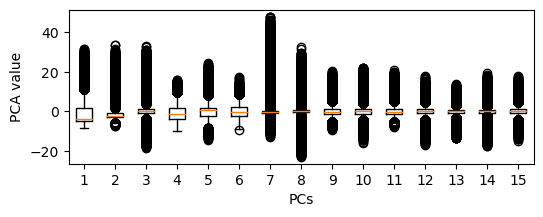

In [14]:
# Check ranges of individual PCs
rcParams['figure.figsize']=(6,2)
_=plt.boxplot(adata_embed.X)
plt.ylabel('PCA value')
plt.xlabel('PCs')

In [5]:
# Compute ASW
asw, asw_macro, asw_data_label=asw_batch(
    X=adata_embed.X,
    batches=adata_embed.obs['system'], 
    labels=adata_embed.obs['cluster'])

In [7]:
asws={
    'asw_micro':asw,
    'asw_macro':asw_macro,
    'asw_data_label':asw_data_label
}
for k,v in asws.items():
    print(k)
    print(v)
    print('\n')

asw_micro
0.3634098


asw_macro
0.36087975


asw_data_label
ASPC              0.367984
LEC               0.374995
SMC               0.388620
b_cell            0.347361
dendritic_cell    0.337995
endothelial       0.454070
macrophage        0.274568
mast_cell         0.387643
monocyte          0.321394
neutrophil        0.441439
nk_cell           0.333198
pericyte          0.317447
t_cell            0.344722
dtype: float32




In [8]:
pkl.dump({'asw_batch':asws},open(path_save+'adiposeHsSAT_sc_sn_embed_integrationMetrics.pkl','wb'))

# Moran's I for eval
Find genes that would be appropriate for computing Moran's I on for evaluation in every sample-cell type group (of appropriate size) by computing Moran's I on per-sample non integrated data. This can then also be used as a reference later on to compute relative preservation of Moran's I.


In [4]:
adata=sc.read(path_save+'adiposeHsSAT_sc_sn.h5ad')

In [12]:
# Potential groups to compute Moran's I on (batch-system and group)
pd.crosstab(adata.obs.donor_id,adata.obs.cluster)

cluster,ASPC,LEC,SMC,adipocyte,b_cell,dendritic_cell,endometrium,endothelial,macrophage,mast_cell,monocyte,neutrophil,nk_cell,pericyte,t_cell
donor_id,,,,,,,,,,,,,,,
EPI235,5107,48,5,0,21,647,1,107,373,0,339,2,364,3,575
EPI236,4557,11,2,0,6,65,2,38,28,8,34,0,56,3,178
EPI237,1007,37,25,0,6,30,0,79,8,0,24,0,40,4,92
EPI238,3028,31,10,0,11,325,0,68,150,22,207,0,164,7,532
EPI239,3082,21,17,0,6,223,0,167,908,20,67,0,14,15,67
EPI240,407,0,0,0,0,0,0,0,0,0,0,0,0,0,0
EPI242,2844,68,29,0,0,78,0,225,125,9,15,0,10,31,66
EPI248,654,0,0,0,5,67,0,0,30,23,48,0,82,0,138
EPI249,270,0,0,0,1,35,0,0,37,7,12,0,13,0,42


In [24]:
# Filtered groups based on N cells
groups=adata.obs.groupby(['cluster','system','donor_id']).size()
groups=groups[groups>=500]
display(groups)
print('N cell types',groups.index.get_level_values('cluster').nunique())

cluster         system  donor_id
ASPC            0       EPI235      5107
                        EPI236      4557
                        EPI237      1007
                        EPI238      3028
                        EPI239      3082
                        EPI242      2844
                        EPI248       654
                1       EPI266      1534
                        TP01        8283
                        TP02        1354
                        TP04         523
                        UP1009-S     615
                        UP1010-S    1257
                        UP1018-S    3061
SMC             1       TP01         837
adipocyte       1       EPI266      1369
                        TP01        7937
                        TP02        1502
                        UP1009-S     591
                        UP1010-S    1237
                        UP1018-S    1004
dendritic_cell  0       EPI235       647
endothelial     1       EPI266      1774
                        

N cell types 8


In [35]:
# Compute Moran's I per group
data=[]
for group in groups.index:
    # Group adata
    print(group)
    adata_sub=adata[
        (adata.obs.cluster==group[0]).values&\
        (adata.obs.system==group[1]).values&\
        (adata.obs.donor_id==group[2]).values,:].copy()
    # Remove lowly expr genes before Moran's I computation as they will be less likely relevant
    # As this is done per small cell group within sample+cell type and HVGs there is not many genes (200-500)
    # so all can be used for Moran's I computation
    sc.pp.filter_genes(adata_sub, min_cells=adata_sub.shape[0]*0.1) 
    # Compute embedding of group
    sc.pp.pca(adata_sub, n_comps=15)
    sc.pp.neighbors(adata_sub, n_pcs=15)
    # Compute I
    morans_i=sc.metrics._morans_i._morans_i(
        g=adata_sub.obsp['connectivities'],
        vals=adata_sub.X.T)
    # Save data
    morans_i=pd.DataFrame({'morans_i':morans_i},index=adata_sub.var_names)
    morans_i['group']=group[0]
    morans_i['system']=group[1]
    morans_i['batch']=group[2]
    data.append(morans_i)
data=pd.concat(data,axis=0)

('ASPC', 0, 'EPI235')


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


('ASPC', 0, 'EPI236')
('ASPC', 0, 'EPI237')
('ASPC', 0, 'EPI238')
('ASPC', 0, 'EPI239')
('ASPC', 0, 'EPI242')
('ASPC', 0, 'EPI248')
('ASPC', 1, 'EPI266')
('ASPC', 1, 'TP01')
('ASPC', 1, 'TP02')
('ASPC', 1, 'TP04')
('ASPC', 1, 'UP1009-S')
('ASPC', 1, 'UP1010-S')
('ASPC', 1, 'UP1018-S')
('SMC', 1, 'TP01')
('adipocyte', 1, 'EPI266')
('adipocyte', 1, 'TP01')
('adipocyte', 1, 'TP02')
('adipocyte', 1, 'UP1009-S')
('adipocyte', 1, 'UP1010-S')
('adipocyte', 1, 'UP1018-S')
('dendritic_cell', 0, 'EPI235')
('endothelial', 1, 'EPI266')
('endothelial', 1, 'TP01')
('endothelial', 1, 'TP02')
('endothelial', 1, 'UP1018-S')
('macrophage', 0, 'EPI239')
('macrophage', 1, 'TP01')
('macrophage', 1, 'TP02')
('macrophage', 1, 'UP1010-S')
('macrophage', 1, 'UP1018-S')
('nk_cell', 1, 'TP01')
('t_cell', 0, 'EPI235')
('t_cell', 0, 'EPI238')
('t_cell', 1, 'TP01')


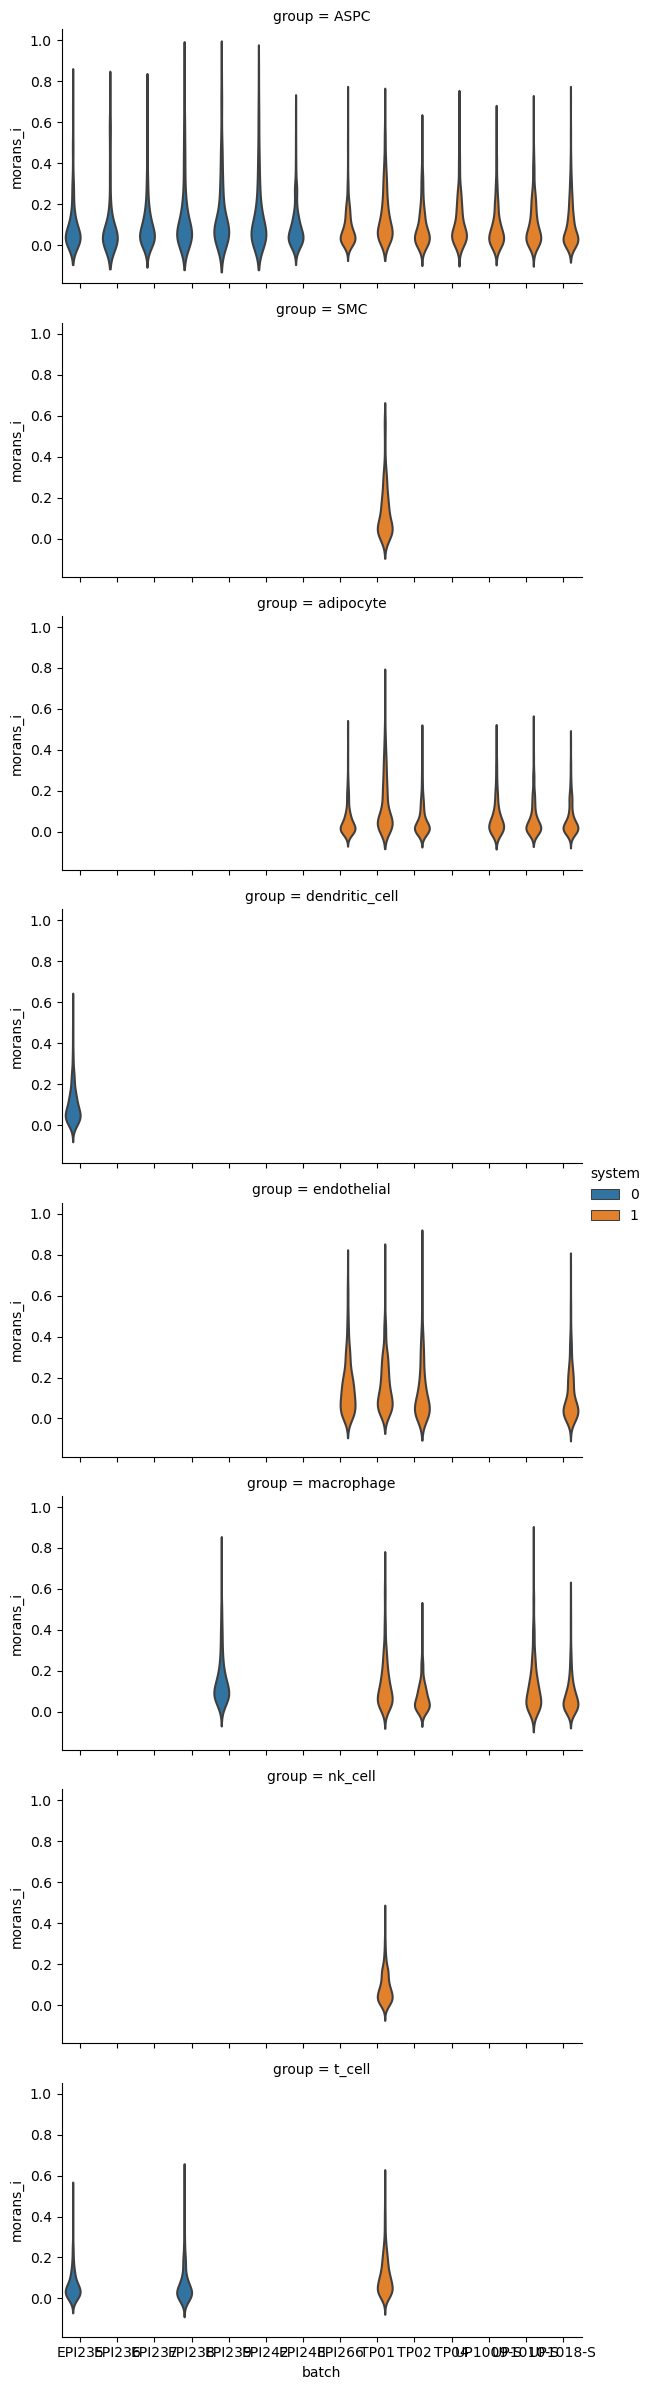

In [44]:
# Moran's I distn accross groups
sb.catplot(x='batch',y='morans_i',hue='system',row='group',data=data,kind='violin',
           inner=None,height=3,aspect=2)

In [ ]:
# Moran's I thr
thr_mi=0.2

In [47]:
# N genes per group at certain thr
data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum())

group           system  batch   
ASPC            0       EPI235       39
                        EPI236       23
                        EPI237       37
                        EPI238       41
                        EPI239       45
                        EPI242       44
                        EPI248       39
                1       EPI266       38
                        TP01        109
                        TP02         62
                        TP04         86
                        UP1009-S     45
                        UP1010-S     89
                        UP1018-S     74
SMC             1       TP01         70
adipocyte       1       EPI266       26
                        TP01         88
                        TP02         37
                        UP1009-S     36
                        UP1010-S     39
                        UP1018-S     30
dendritic_cell  0       EPI235       56
endothelial     1       EPI266      126
                        TP01        140
       

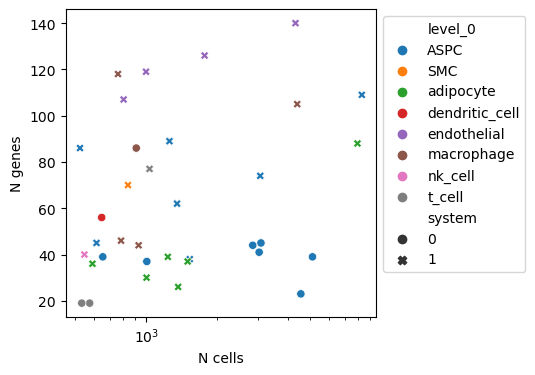

In [68]:
# N genes vs N cells in group
rcParams['figure.figsize']=(4,4)
sb.scatterplot(x='N cells',y='N genes',hue='level_0',style='system',
           data=pd.concat(
    [data.groupby(['group','system','batch']).apply(lambda x: (x['morans_i']>=thr_mi).sum()).rename('N genes'),
    groups.rename('N cells')],axis=1).reset_index())
plt.legend(bbox_to_anchor=(1,1))
plt.xscale('log')

C: Thr of 0.2 seems to separate in general approximately between highly and lowly variable genes and has at least some genes for every group and not too many in any of the groups.

C: There is no clear bias between N cells in group and N genes.

C: Selected genes may not be diverse though - they may capture the same pattern and maybe more subtle patterns are at lower Moran's I.

In [87]:
# Prepare selected genes for saving (fileterd genes&I per group)
selected=list()
for group,data_sub in data.groupby(['group','system','batch']):
    group=dict(zip(['group','system','batch'],group))
    group['genes']=(data_sub.query('morans_i>=@thr_mi')['morans_i']+1)/2
    selected.append(group)

In [7]:
# Save
pkl.dump(selected,open(path_save+'adiposeHsSAT_sc_sn_moransiGenes.pkl','wb'))

# Batch effects within and between systems

In [3]:
adata=sc.read(path_save+'adiposeHsSAT_sc_sn.h5ad')

In [10]:
# Compute PCA on the whole data
adata_scl=adata.copy()
sc.pp.scale(adata_scl)
n_pcs=15
sc.pp.pca(adata_scl, n_comps=n_pcs)
pca=pd.DataFrame(adata_scl.obsm['X_pca'],index=adata_scl.obs_names)
del adata_scl

In [66]:
# Average PCA accross system-batch-group pseudobulks. 
# Only use pseudobulks with at least 50 cells
# Only use cell types with at least 3 samples per system
pca[['system','batch','group']]=adata.obs[['system', 'donor_id', 'cluster']]
pca_pb=pca.groupby(['system','batch','group'])
pca_mean=pca_pb.mean()
pb_size=pca_pb.size()
# Remove samples with too little cells
filtered_pb=pb_size.index[pb_size>=50]
# Get pbs/cts where both systems have enough samples
n_samples_system=filtered_pb.to_frame().rename({'group':'group_col'},axis=1).groupby(
    'group_col',observed=True)['system'].value_counts().rename('n_samples').reset_index()
cts=set(n_samples_system.query('system==0 & n_samples>=3').group_col)&\
    set(n_samples_system.query('system==1 & n_samples>=3').group_col)
filtered_pb=filtered_pb[filtered_pb.get_level_values(2).isin(cts)]
pca_mean=pca_mean.loc[filtered_pb,:]

In [101]:
# Compute per-ct distances of samples within and between systems
distances={}
for ct in cts:
    pca_s0=pca_mean[(pca_mean.index.get_level_values(0)==0) &
                    (pca_mean.index.get_level_values(2)==ct)]
    pca_s1=pca_mean[(pca_mean.index.get_level_values(0)==1) &
                    (pca_mean.index.get_level_values(2)==ct)]
    d_s0=euclidean_distances(pca_s0)[np.triu_indices(pca_s0.shape[0],k=1)]
    d_s1=euclidean_distances(pca_s1)[np.triu_indices(pca_s1.shape[0],k=1)]
    d_s0s1=euclidean_distances(pca_s0,pca_s1).ravel()
    distances[ct]={'s0':d_s0,'s1':d_s1,'s0s1':d_s0s1}

In [106]:
# Save distances
pkl.dump(distances,open(path_save+'adiposeHsSAT_sc_sn_PcaSysBatchDist.pkl','wb'))

In [3]:
#distances=pkl.load(open(path_save+'adiposeHsSAT_sc_sn_PcaSysBatchDist.pkl','rb'))

In [112]:
# Prepare df for plotting
plot=[]
for ct,dat in distances.items():
    for comparison,dist in dat.items():
        dist=pd.DataFrame(dist,columns=['dist'])
        dist['group']=ct
        dist['comparison']=comparison
        plot.append(dist)
plot=pd.concat(plot)

/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 9.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 21.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/net/bmc-lab5/data/kellis/users/khrovati/miniconda/envs/analysis/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 14.3% of the points cannot be placed; yo

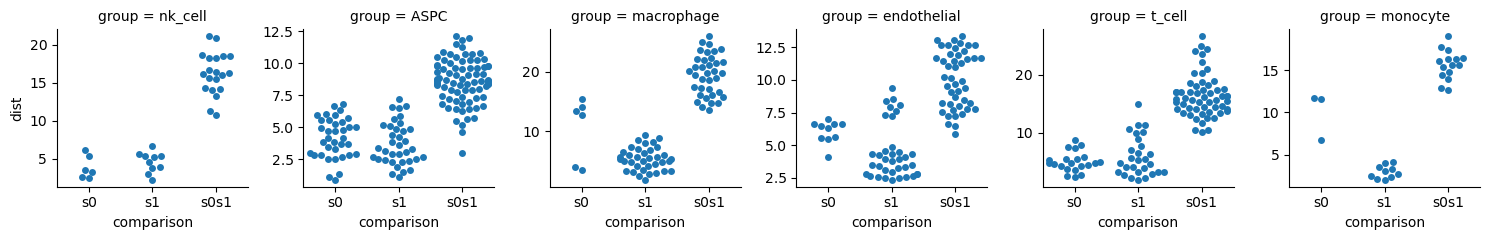

In [138]:
# Plot distances
sb.catplot(x='comparison',y='dist',col='group',
           data=plot.reset_index(drop=True),kind='swarm',
           sharey=False, height=2.5,aspect=1 )

Evaluate statisticsal significance

In [20]:
# Compute significance of differences within and accross systems
signif=[]
for ct,dat in distances.items():
    for ref in ['s0','s1']:
        u,p=mannwhitneyu( dat[ref],dat['s0s1'],alternative='less')
        signif.append(dict( cell_type=ct,system=ref, u=u,pval=p,
                           n_system=dat[ref].shape[0],n_crossystem=dat['s0s1'].shape[0]))
signif=pd.DataFrame(signif)
signif['padj']=multipletests(signif['pval'],method='fdr_bh')[1]

In [21]:
signif

,cell_type,system,u,pval,n_system,n_crossystem,padj
0,nk_cell,s0,0.0,4.343483e-06,6,20,6.515224e-06
1,nk_cell,s1,0.0,6.004721e-06,10,20,7.205665e-06
2,ASPC,s0,89.0,3.194510e-16,36,81,1.916706e-15
3,ASPC,s1,80.0,2.062908e-16,36,81,1.916706e-15
4,macrophage,s0,6.0,5.718876e-06,6,36,7.205665e-06
5,macrophage,s1,0.0,1.523170e-13,36,36,6.092682e-13
6,endothelial,s0,14.0,2.179505e-06,10,45,3.736295e-06
7,endothelial,s1,84.0,2.684430e-12,36,45,6.442633e-12
8,t_cell,s0,0.0,9.107229e-12,21,56,1.821446e-11
9,t_cell,s1,30.0,4.346527e-13,28,56,1.303958e-12


In [22]:
# Save signif
signif.to_csv(path_save+'adiposeHsSAT_sc_sn_PcaSysBatchDist_Signif.tsv',sep='\t',index=False)